# PySpark clustering

In [107]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, col, count, desc, countDistinct
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

from src.customEncoder import CustomEncoder

ModuleNotFoundError: No module named 'src'

In [19]:
spark = SparkSession.builder.appName("session_new_1").getOrCreate()

In [20]:
data = spark.read.csv("archive/churn-bigml-80.csv", header=True, inferSchema=True)

# header=True - for reading names of columnes
# inferSchema=True - for correct reading columns types

### Practise

In [105]:
type(data)

pyspark.sql.dataframe.DataFrame

In [106]:
data.head(5)

[Row(State='KS', Account length=128, Area code=415, International plan='No', Voice mail plan='Yes', Number vmail messages=25, Total day minutes=265.1, Total day calls=110, Total day charge=45.07, Total eve minutes=197.4, Total eve calls=99, Total eve charge=16.78, Total night minutes=244.7, Total night calls=91, Total night charge=11.01, Total intl minutes=10.0, Total intl calls=3, Total intl charge=2.7, Customer service calls=1, Churn=False),
 Row(State='OH', Account length=107, Area code=415, International plan='No', Voice mail plan='Yes', Number vmail messages=26, Total day minutes=161.6, Total day calls=123, Total day charge=27.47, Total eve minutes=195.5, Total eve calls=103, Total eve charge=16.62, Total night minutes=254.4, Total night calls=103, Total night charge=11.45, Total intl minutes=13.7, Total intl calls=3, Total intl charge=3.7, Customer service calls=1, Churn=False),
 Row(State='NJ', Account length=137, Area code=415, International plan='No', Voice mail plan='No', Num

Selecting

In [23]:
data.select("State").show(3)

+-----+
|State|
+-----+
|   KS|
|   OH|
|   NJ|
+-----+
only showing top 3 rows



In [24]:
data.select(["State", "Area code"]).show(3)

+-----+---------+
|State|Area code|
+-----+---------+
|   KS|      415|
|   OH|      415|
|   NJ|      415|
+-----+---------+
only showing top 3 rows



Dtypes

In [25]:
print(data.dtypes)

[('State', 'string'), ('Account length', 'int'), ('Area code', 'int'), ('International plan', 'string'), ('Voice mail plan', 'string'), ('Number vmail messages', 'int'), ('Total day minutes', 'double'), ('Total day calls', 'int'), ('Total day charge', 'double'), ('Total eve minutes', 'double'), ('Total eve calls', 'int'), ('Total eve charge', 'double'), ('Total night minutes', 'double'), ('Total night calls', 'int'), ('Total night charge', 'double'), ('Total intl minutes', 'double'), ('Total intl calls', 'int'), ('Total intl charge', 'double'), ('Customer service calls', 'int'), ('Churn', 'boolean')]


In [26]:
data.describe().show()

+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|summary|State|    Account length|         Area code|International plan|Voice mail plan|Number vmail messages| Total day minutes|   Total day calls|  Total day charge| Total eve minutes|   Total eve calls|  Total eve charge|Total night minutes| Total night calls|Total night charge|Total intl minutes|  Total intl calls| Total intl charge|Customer service calls|
+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------

Add column

In [27]:
data = data.withColumn("New Area code", data["Area code"]*2)
data.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+-------------+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|New Area code|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+------

Drop column

In [28]:
data = data.drop("New Area code")

Rename

In [29]:
data = data.withColumnRenamed("Area code", "Code of area")
data = data.withColumnRenamed("Code of area", "Area code")

Handling missing values

In [30]:
print(f"Количество нановых колонок:", data.count()-data.na.drop(how="all").count())

Количество нановых колонок: 0


In [31]:
print(f"Количество ячеек с пропусками пропусков:", data.count()-data.na.drop(how="any").count())

Количество ячеек с пропусками пропусков: 0


In [32]:
working_cols = ["Total day minutes", "Total day calls", "Total eve minutes"]
data.na.drop(how="any", thresh=2, subset=working_cols).show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

Filling missing values

In [33]:
data.na.fill(value="Missing value", subset="Area code").show(2)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

In [34]:
from pyspark.ml.feature import Imputer 

col_subset = ["Total day minutes", "Number vmail messages"]
imputer = Imputer(
    inputCols=col_subset,
    outputCols=[f"{col_name}_imputed" for col_name in col_subset]
    ).setStrategy("mean")

In [35]:
imputer.fit(data).transform(data).show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+-------------------------+-----------------------------+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|Total day minutes_imputed|Number vmail messages_imputed|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-------------

Filtering

In [36]:
data.filter(~((data['Total intl calls'] < 5) & (data['Total intl calls'] > 2))).select("Total intl calls").count()

1619

Aggregating and grouping


In [37]:
data.groupBy("State").avg("Total intl calls").cache().sort(desc("avg(Total intl calls)")).show(5) 

+-----+---------------------+
|State|avg(Total intl calls)|
+-----+---------------------+
|   AZ|    5.288888888888889|
|   ND|    5.136363636363637|
|   NH|                  5.0|
|   WY|    4.924242424242424|
|   MS|    4.895833333333333|
+-----+---------------------+
only showing top 5 rows



Ml

In [38]:
cols = ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']
featureassembler=VectorAssembler(inputCols=cols, outputCol="Input")

In [39]:
output=featureassembler.transform(data)

In [40]:
output.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+--------------------+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|               Input|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+----------

In [41]:
final_data=output.select(["Input", "Churn"])

In [42]:
final_data.show(5)

+--------------------+-----+
|               Input|Churn|
+--------------------+-----+
|[128.0,415.0,25.0...|false|
|[107.0,415.0,26.0...|false|
|[137.0,415.0,0.0,...|false|
|[84.0,408.0,0.0,2...|false|
|[75.0,415.0,0.0,1...|false|
+--------------------+-----+
only showing top 5 rows



In [43]:
final_data=final_data.withColumn("Churn_int", col("Churn").cast("int"))
# df = df.withColumn("boolean_column_int", col("boolean_column").cast("int"))

In [44]:
from pyspark.ml.regression import LinearRegression

train_data, test_data = final_data.randomSplit([0.75, 0.25])
regressor=LinearRegression(featuresCol="Input", labelCol="Churn_int")
regressor=regressor.fit(train_data)

In [45]:
regressor.coefficients

DenseVector([0.0002, 0.0001, -0.002, -0.218, 0.0004, 1.2897, 0.0747, -0.0002, -0.8729, -0.0997, 0.0002, 2.2217, 0.2251, -0.0106, -0.7843, 0.0535])

In [46]:
preds = regressor.evaluate(test_data)
preds.predictions.show(5)

+--------------------+-----+---------+--------------------+
|               Input|Churn|Churn_int|          prediction|
+--------------------+-----+---------+--------------------+
|[1.0,415.0,0.0,19...|false|        0| 0.17892560941437446|
|[1.0,415.0,26.0,1...|false|        0|0.008844205602314748|
|[7.0,415.0,0.0,20...|false|        0|  0.2772575897952739|
|[11.0,408.0,24.0,...|false|        0| 0.11043630323605053|
|[13.0,408.0,0.0,2...|false|        0| 0.26014738542659815|
+--------------------+-----+---------+--------------------+
only showing top 5 rows



In [47]:
preds.meanAbsoluteError

0.2298348514553787

### EDA

In [48]:
print(f"Размерность датафрейма:", (data.count(), len(data.columns)))

Размерность датафрейма: (2666, 20)


In [49]:
print(data.columns)

['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']


In [50]:
data.describe().show()

+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|summary|State|    Account length|         Area code|International plan|Voice mail plan|Number vmail messages| Total day minutes|   Total day calls|  Total day charge| Total eve minutes|   Total eve calls|  Total eve charge|Total night minutes| Total night calls|Total night charge|Total intl minutes|  Total intl calls| Total intl charge|Customer service calls|
+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------

In [103]:
data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



Check all columns for nulls

In [62]:
null_check_collection = data.select([
    count(when(col(data_col).isNull(), data_col))\
    .alias(data_col)
    for data_col in data.columns]
).cache().collect()[0]

for column, null_count in null_check_collection.asDict().items():
    print(f"'{column}': {null_count}")

'State': 0
'Account length': 0
'Area code': 0
'International plan': 0
'Voice mail plan': 0
'Number vmail messages': 0
'Total day minutes': 0
'Total day calls': 0
'Total day charge': 0
'Total eve minutes': 0
'Total eve calls': 0
'Total eve charge': 0
'Total night minutes': 0
'Total night calls': 0
'Total night charge': 0
'Total intl minutes': 0
'Total intl calls': 0
'Total intl charge': 0
'Customer service calls': 0
'Churn': 0


In [73]:
col_unique_values = {}  # for one hot encoding
 
for col_name in data.columns:
    count_unique = data.select(col_name).agg(countDistinct(col_name)).collect()[0][0]
    print(f"Уникальных значений в колонке {col_name}: {count_unique}")
    col_unique_values[col_name] = count_unique

Уникальных значений в колонке State: 51
Уникальных значений в колонке Account length: 205
Уникальных значений в колонке Area code: 3
Уникальных значений в колонке International plan: 2
Уникальных значений в колонке Voice mail plan: 2
Уникальных значений в колонке Number vmail messages: 42
Уникальных значений в колонке Total day minutes: 1489
Уникальных значений в колонке Total day calls: 115
Уникальных значений в колонке Total day charge: 1489
Уникальных значений в колонке Total eve minutes: 1442
Уникальных значений в колонке Total eve calls: 120
Уникальных значений в колонке Total eve charge: 1301
Уникальных значений в колонке Total night minutes: 1444
Уникальных значений в колонке Total night calls: 118
Уникальных значений в колонке Total night charge: 885
Уникальных значений в колонке Total intl minutes: 158
Уникальных значений в колонке Total intl calls: 21
Уникальных значений в колонке Total intl charge: 158
Уникальных значений в колонке Customer service calls: 10
Уникальных значе

Categorical columns

In [94]:
# will be encoded by one hot encoder
one_hot_cols = [
    "Area code", 
    "International plan",
    "Churn", 
    "Voice mail plan"
]

# will be encoded by custom encoder class by state frequencies in dataset
freq_cols = [
    "State"
]

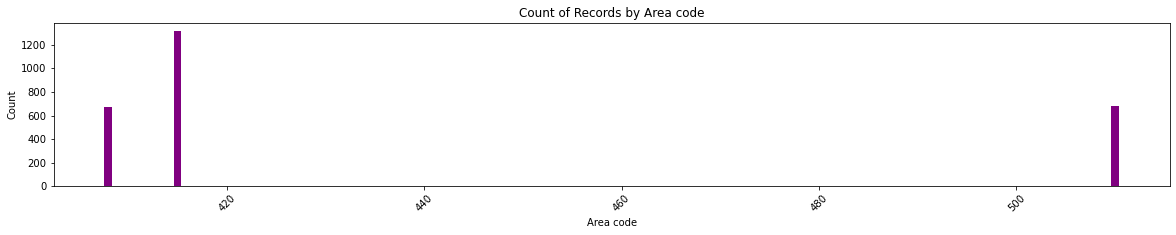

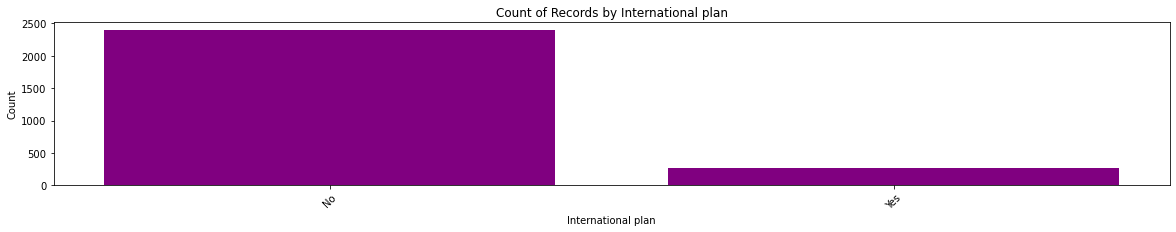

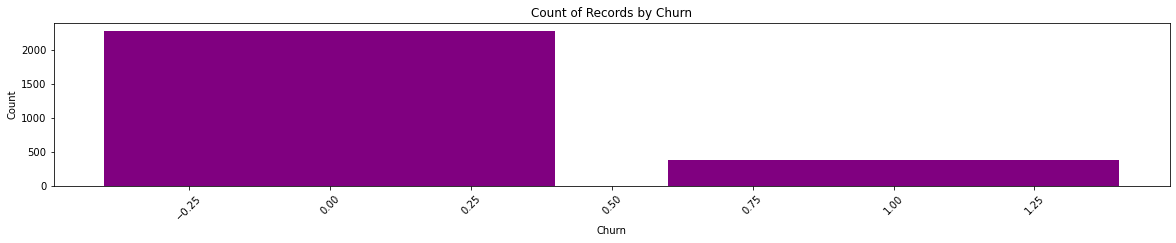

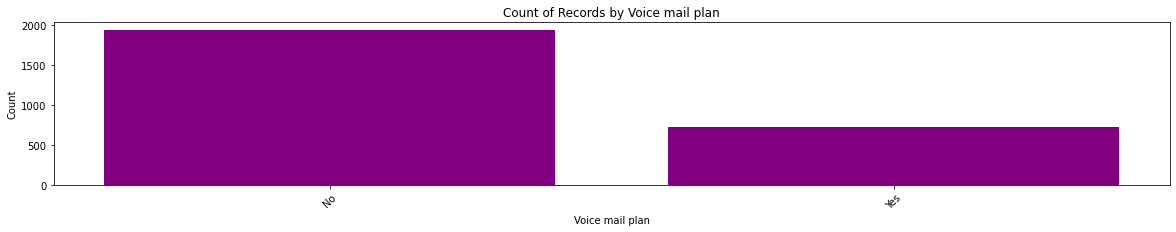

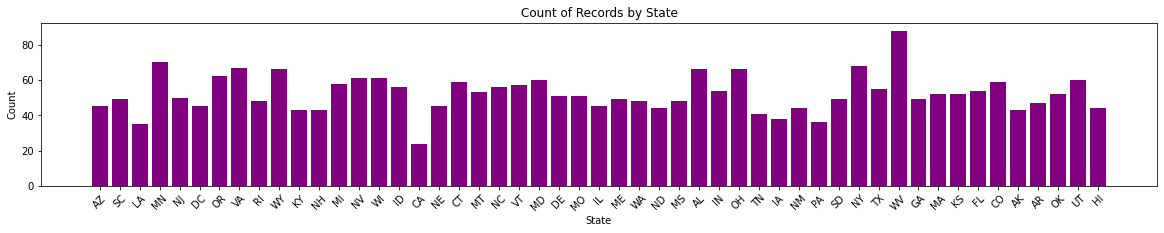

In [69]:
for cat_col in one_hot_cols + freq_cols:
    grouped_data = data.groupby(cat_col).count().cache().toPandas()
    
    plt.figure(figsize=(20, 3))
    plt.bar(grouped_data[cat_col], grouped_data['count'], color='purple')
    plt.xlabel(cat_col)
    plt.ylabel('Count')
    plt.title(f'Count of Records by {cat_col}')
    plt.xticks(rotation=45)
    plt.show()

In [71]:
data.explain(True)

== Parsed Logical Plan ==
Project [State#1838, Account length#1839, Code of area#3160 AS Area code#3181, International plan#1841, Voice mail plan#1842, Number vmail messages#1843, Total day minutes#1844, Total day calls#1845, Total day charge#1846, Total eve minutes#1847, Total eve calls#1848, Total eve charge#1849, Total night minutes#1850, Total night calls#1851, Total night charge#1852, Total intl minutes#1853, Total intl calls#1854, Total intl charge#1855, Customer service calls#1856, Churn#1857]
+- Project [State#1838, Account length#1839, Area code#1840 AS Code of area#3160, International plan#1841, Voice mail plan#1842, Number vmail messages#1843, Total day minutes#1844, Total day calls#1845, Total day charge#1846, Total eve minutes#1847, Total eve calls#1848, Total eve charge#1849, Total night minutes#1850, Total night calls#1851, Total night charge#1852, Total intl minutes#1853, Total intl calls#1854, Total intl charge#1855, Customer service calls#1856, Churn#1857]
   +- Proje

### Preprocessing

In [72]:
data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [80]:
out_one_hot_cols = [f"{col}_{i}" for col in one_hot_cols for i in range(col_unique_values[col])]

one_hot_encoder = OneHotEncoder(inputCols=one_hot_cols, outputCols=out_one_hot_cols)

In [101]:
grouped_data = data.groupby("State").count().cache().collect()
state_freq = {row['State']: row['count'] for row in grouped_data}

state_encoder = CustomEncoder(encoding_dict=state_freq, inputCol=freq_cols[0], outputCol="State_0")

In [100]:
data.columns

['State',
 'Account length',
 'Area code',
 'International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']

In [ ]:
all_cols = data.columns

featureassembler = VectorAssembler(
    inputCols=[i for i in all_cols if i not in one_hot_cols + freq_cols + ["Churn"]] + out_one_hot_cols + ["State_0"], \
    outputCol="features"
)

In [ ]:
pipeline = Pipeline(stages=[one_hot_encoder, state_encoder, featureassembler])